In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
torch.manual_seed(15)

In [4]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.randn(train_data_length)
train_data[:, 1] = (torch.sin(train_data[:, 0])/ (train_data[:, 0])) - ((train_data[:, 0])/10)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

train_data2 = torch.zeros((train_data_length, 2))
train_data2[:, 0] = torch.randn(train_data_length)
train_data2[:, 1] = (0.2*(torch.sin(3*(train_data2[:, 0]))) * (train_data2[:, 0])**2)
train_labels2 = torch.zeros(train_data_length)
train_set2 = [(train_data2[i], train_labels2[i]) for i in range(train_data_length)]

Для лучшего анализа работы обученной модели построим дополнительный график повышенной сложности:

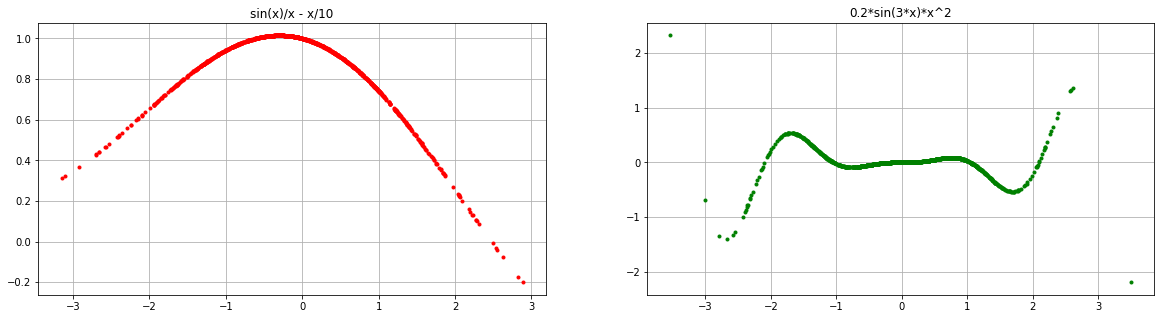

In [5]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_title('sin(x)/x - x/10')
ax1.grid(True)
ax1.plot(train_data[:, 0], train_data[:, 1], ".", color='r')

ax2.set_title('0.2*sin(3*x)*x^2')
ax2.grid(True)
ax2.plot(train_data2[:, 0], train_data2[:, 1], ".", color='g')

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=batch_size, shuffle=True)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

Обучение сети для первого графика:

In [9]:
lr = 0.001
num_epochs = 2000
loss_function = torch.nn.BCELoss()

In [10]:
generator = Generator()
discriminator = Discriminator()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
      
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        if epoch % 100 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}") 

Epoch: 0 Loss D.: 0.3639071583747864
Epoch: 0 Loss G.: 1.5615867376327515
Epoch: 100 Loss D.: 0.6451308131217957
Epoch: 100 Loss G.: 0.7097068428993225
Epoch: 200 Loss D.: 0.6632488965988159
Epoch: 200 Loss G.: 0.7638133764266968
Epoch: 300 Loss D.: 0.7396841645240784
Epoch: 300 Loss G.: 0.5801386833190918
Epoch: 400 Loss D.: 0.6854815483093262
Epoch: 400 Loss G.: 0.7046387195587158
Epoch: 500 Loss D.: 0.6886464357376099
Epoch: 500 Loss G.: 0.6922067999839783
Epoch: 600 Loss D.: 0.6907821893692017
Epoch: 600 Loss G.: 0.6911368370056152
Epoch: 700 Loss D.: 0.6926401257514954
Epoch: 700 Loss G.: 0.6968660950660706
Epoch: 800 Loss D.: 0.6954510807991028
Epoch: 800 Loss G.: 0.685655415058136
Epoch: 900 Loss D.: 0.6950152516365051
Epoch: 900 Loss G.: 0.6940191388130188
Epoch: 1000 Loss D.: 0.685448408126831
Epoch: 1000 Loss G.: 0.6986267566680908
Epoch: 1100 Loss D.: 0.6942548751831055
Epoch: 1100 Loss G.: 0.695698082447052
Epoch: 1200 Loss D.: 0.6938145756721497
Epoch: 1200 Loss G.: 0.6797

In [12]:
latent_space_samples = torch.randn(1000, 2)
generated_samples = generator(latent_space_samples)

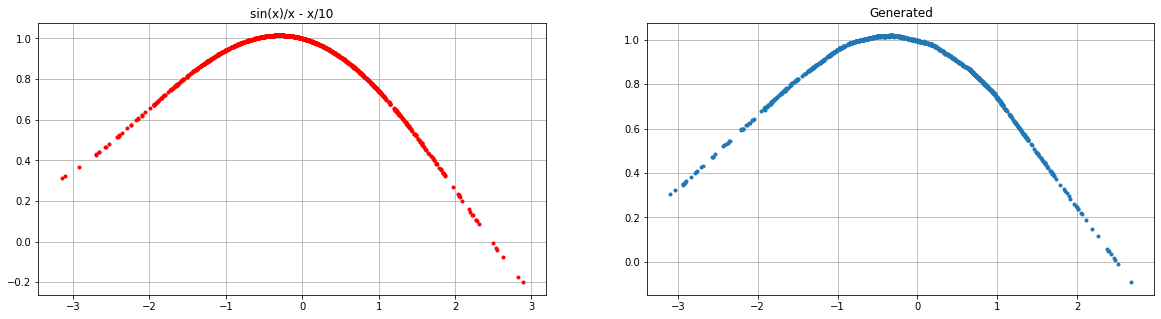

In [13]:
generated_samples = generated_samples.detach()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_title('sin(x)/x - x/10')
ax1.grid(True)
ax1.plot(train_data[:, 0], train_data[:, 1], ".", color='r')

ax2.set_title('Generated')
ax2.grid(True)
ax2.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

Обучим модель для второго графика:

In [14]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader2):
      
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        if epoch % 100 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}") 

Epoch: 0 Loss D.: 0.4011913239955902
Epoch: 0 Loss G.: 0.681782066822052
Epoch: 100 Loss D.: 0.6522839069366455
Epoch: 100 Loss G.: 0.7595942616462708
Epoch: 200 Loss D.: 0.6712222099304199
Epoch: 200 Loss G.: 0.7314609289169312
Epoch: 300 Loss D.: 0.6931800246238708
Epoch: 300 Loss G.: 0.712434709072113
Epoch: 400 Loss D.: 0.6619136333465576
Epoch: 400 Loss G.: 0.711402416229248
Epoch: 500 Loss D.: 0.6172513961791992
Epoch: 500 Loss G.: 0.729020893573761
Epoch: 600 Loss D.: 0.6032484173774719
Epoch: 600 Loss G.: 0.8564910888671875
Epoch: 700 Loss D.: 0.5130791664123535
Epoch: 700 Loss G.: 1.1378247737884521
Epoch: 800 Loss D.: 0.415614515542984
Epoch: 800 Loss G.: 1.3611592054367065
Epoch: 900 Loss D.: 0.5789532661437988
Epoch: 900 Loss G.: 1.2409452199935913
Epoch: 1000 Loss D.: 0.5466920733451843
Epoch: 1000 Loss G.: 1.5681707859039307
Epoch: 1100 Loss D.: 0.48241710662841797
Epoch: 1100 Loss G.: 0.9675742387771606
Epoch: 1200 Loss D.: 0.47131818532943726
Epoch: 1200 Loss G.: 1.4144

In [15]:
latent_space_samples = torch.randn(500, 2)
generated_samples2 = generator(latent_space_samples)

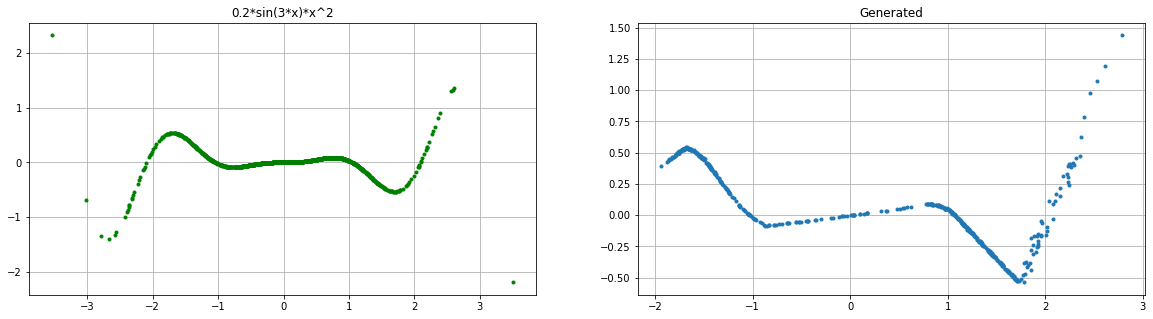

In [16]:
generated_samples2 = generated_samples2.detach()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_title('0.2*sin(3*x)*x^2')
ax1.grid(True)
ax1.plot(train_data2[:, 0], train_data2[:, 1], ".", color='g')

ax2.set_title('Generated')
ax2.grid(True)
ax2.plot(generated_samples2[:, 0], generated_samples2[:, 1], ".")

Как видно по результатам, несложный по форме график сгенерировался без особых проблем, но со сложным возникли трудности даже при 2000 эпохах. Отсутствуют мелкие детали, искажены пропорции и формы. Вероятно, для достижения лучших результатов необходимо увеличивать количество эпох.